In [94]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

'''  
optimize markowitz to lowest risk
'''

'  \noptimize markowitz to lowest risk\n'

In [95]:
# read in data 
data = pd.read_csv('case2data.csv', index_col = 0)
train, test = train_test_split(data, test_size = 0.2, shuffle = False)

In [96]:
def func(x, cov):
    return np.dot(np.dot(x, cov), x)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

In [97]:
# uniform weights
def calculateWeights(running_price_paths, running_weights_paths):
    covi = np.cov(running_price_paths[-21:].T)
    w = running_weights_paths[len(running_weights_paths) - 1]
    
    weights = minimize(func, w, covi)
    ret = weights.x / (np.sum(weights.x))
    
    
    return softmax(ret)

In [98]:
## given grading scheme
class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.running_weights_paths = [[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]]
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        ### edit: used np.append to make this work
        self.running_price_paths.loc[len(self.running_price_paths.index)] = asset_prices
        #self.running_price_paths. = np.append(self.running_price_paths, asset_prices)
        #print(self.running_price_paths)
    
        ### TODO Implement your code here
        weights = calculateWeights(self.running_price_paths, self.running_weights_paths)
        self.running_weights_paths.append(weights)
        
        return weights
    
    
def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

0.09872694928262812


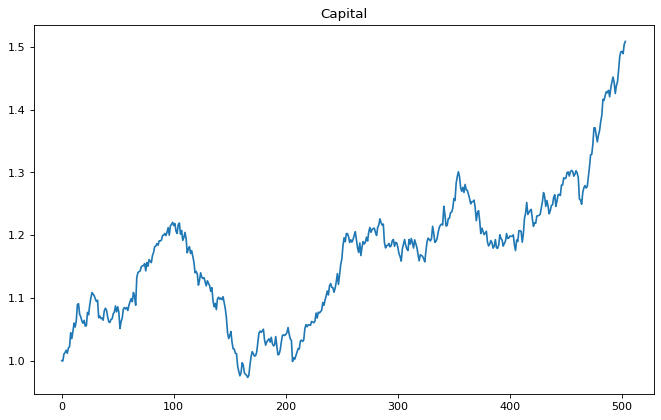

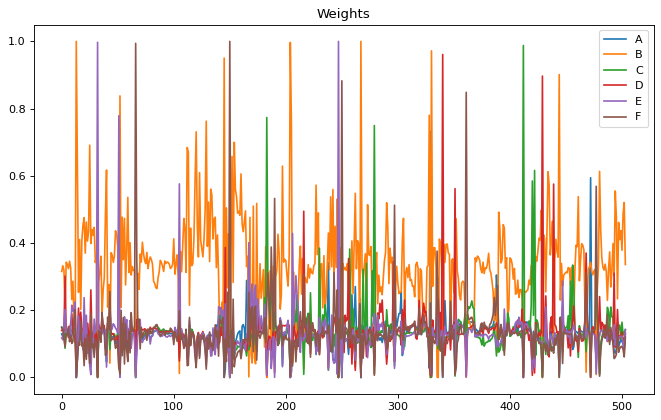

In [93]:
# run simulation
sharpe, capital, weights = grading(train, test)
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(test)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(test)), weights)
plt.legend(test.columns)
plt.show()